In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
from torchvision import models, transforms, datasets


In [3]:
import time
import os
import copy
from tqdm import tqdm

plt.ion()

In [4]:
data_transforms = {
    'train': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(256),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])      
}

In [5]:
dataDir = 'block'
image_datasets = {
    x: datasets.ImageFolder(os.path.join(dataDir, x), data_transforms[x]) for x in ['train', 'val']
}

data_loaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'val']
}

dataset_sizes = {
    x: len(image_datasets[x]) for x in ['train', 'val']
}

class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



In [6]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

    plt.pause(0.001)

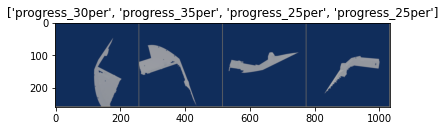

In [7]:
inputs, classes = next(iter(data_loaders['train']))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [8]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in data_loaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [10]:
model_ft = models.resnext101_32x8d(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth" to /home/tim/.cache/torch/hub/checkpoints/resnext101_32x8d-8ba56ff5.pth
100%|██████████| 340M/340M [00:06<00:00, 56.7MB/s]


In [11]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.9056 Acc: 0.6954
val Loss: 1.3162 Acc: 0.7335

Epoch 1/24
----------
train Loss: 0.2597 Acc: 0.9175
val Loss: 1.0514 Acc: 0.7756

Epoch 2/24
----------
train Loss: 0.1739 Acc: 0.9441
val Loss: 1.8258 Acc: 0.7046

Epoch 3/24
----------
train Loss: 0.0990 Acc: 0.9687
val Loss: 2.6583 Acc: 0.6551

Epoch 4/24
----------
train Loss: 0.0828 Acc: 0.9717
val Loss: 0.7445 Acc: 0.8412

Epoch 5/24
----------
train Loss: 0.0667 Acc: 0.9779
val Loss: 1.3317 Acc: 0.7640

Epoch 6/24
----------
train Loss: 0.0495 Acc: 0.9837
val Loss: 0.7252 Acc: 0.8445

Epoch 7/24
----------
train Loss: 0.0187 Acc: 0.9930
val Loss: 1.1139 Acc: 0.7793

Epoch 8/24
----------
train Loss: 0.0170 Acc: 0.9927
val Loss: 0.8151 Acc: 0.8296

Epoch 9/24
----------
train Loss: 0.0154 Acc: 0.9948
val Loss: 0.9644 Acc: 0.8061

Epoch 10/24
----------
train Loss: 0.0151 Acc: 0.9935
val Loss: 0.8927 Acc: 0.8127

Epoch 11/24
----------
train Loss: 0.0119 Acc: 0.9952
val Loss: 0.9404 Acc: 0.8135

Ep

In [12]:
torch.save(model_ft.state_dict(), "block_resnext.pth")